In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(train)

           Index  Sentiment                                               Text
0              0          0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1              1          0  is upset that he can't update his Facebook by ...
2              2          0  @Kenichan I dived many times for the ball. Man...
3              3          0    my whole body feels itchy and like its on fire 
4              4          0  @nationwideclass no, it's not behaving at all....
...          ...        ...                                                ...
1048570  1048570          1  Back home, thought I'd done for the week, but ...
1048571  1048571          1           My GrandMa is making Dinenr with my Mum 
1048572  1048572          1  Mid-morning snack time... A bowl of cheese noo...
1048573  1048573          1  @ShaDeLa same here  say it like from the Termi...
1048574  1048574          1             @DestinyHope92 im great thaanks  wbuu?

[1048575 rows x 3 columns]


Number of zeros: 800000
Number of ones: 248575
Total count: 1048575
Percentage of zeros: 76.29%
Percentage of ones: 23.71%


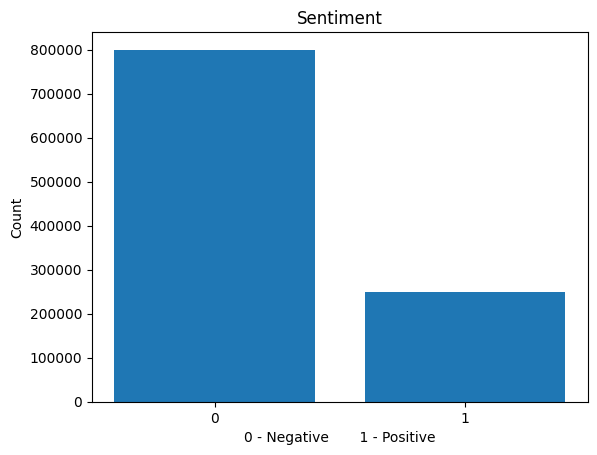

In [3]:
# Exploratory Data Analysis
my_column = train['Sentiment']

    # Calculate some fundamental metrics
num_zeros = my_column.value_counts()[0]
num_ones = my_column.value_counts()[1]
total_count = len(my_column)
percent_zeros = num_zeros / total_count * 100
percent_ones = num_ones / total_count * 100

    # Print the metrics
print(f"Number of zeros: {num_zeros}")
print(f"Number of ones: {num_ones}")
print(f"Total count: {total_count}")
print(f"Percentage of zeros: {percent_zeros:.2f}%")
print(f"Percentage of ones: {percent_ones:.2f}%")

    # Generate a bar chart
fig, ax = plt.subplots()
ax.bar(['0', '1'], [num_zeros, num_ones])
ax.set_xlabel('0 - Negative       1 - Positive')
ax.set_ylabel('Count')
ax.set_title('Sentiment')
plt.show()

In [13]:
# Text Preprocessing
      # Upper to lower
to_lower = lambda x: x.lower() if isinstance(x, str) else x
train['Text'] = train['Text'].apply(to_lower)
test['Text'] = test['Text'].apply(to_lower)

      # Remove words with numbers or "@"
def remove_special_words(text):
    words = text.split()
    new_words = [word for word in words if not any(char.isdigit() or char == '@' for char in word)]
    return ' '.join(new_words)
train['Text'] = train['Text'].apply(remove_special_words)
test['Text'] = test['Text'].apply(remove_special_words)

      # Remove Special Characters
remove_special_chars = lambda x: re.sub(r'[^\w\s]', '', x) if isinstance(x, str) else x
train['Text'] = train['Text'].apply(remove_special_chars)
test['Text'] = test['Text'].apply(remove_special_chars)

      # Word Tokenization & Remove Stop Words
topTrain = train.copy()
topTest = test.copy()
tokenize = lambda x: x.split() if isinstance(x, str) else x
topTrain['Text'] = topTrain['Text'].apply(tokenize)
topTrain = topTrain.sample(n=100000)
topTest['Text'] = topTest['Text'].apply(tokenize)

print(topTrain)

           Index  Sentiment                                               Text
64296      64296          0  [traveling, while, suffering, from, the, flu, ...
858372    858372          1  [miles, taking, in, the, mega, loop, for, next...
1012376  1012376          1  [finlandia, club, is, the, best, club, in, zak...
42501      42501          0  [damn, so, thinkin, bout, me, makes, u, bored,...
587647    587647          0  [sure, all, you, will, have, to, do, is, plug,...
...          ...        ...                                                ...
269188    269188          0  [omg, just, watdlched, neighbours, am, epicly,...
988937    988937          1  [cool, are, you, able, to, blog, about, it, to...
569543    569543          0  [same, here, my, grad, also, completes, last, ...
161659    161659          0  [i, had, a, horrible, dream, it, had, to, do, ...
479219    479219          0  [i, got, too, hopeful, things, arent, looking,...

[100000 rows x 3 columns]


In [14]:
      # Bag of Words Generation -- Word Tokenization & Remove Stop Words
bagOfWords_ = CountVectorizer(token_pattern=r'\b\w+\b', stop_words='english')
X_trainBOW = bagOfWords_.fit_transform(train['Text'])
X_testBOW = bagOfWords_.transform(test['Text'])

      # TF*IDF -- Word Tokenization & Remove Stop Words
tfidf = TfidfVectorizer(token_pattern=r'\b\w+\b', stop_words='english')
X_trainTF = tfidf.fit_transform(train['Text'])
X_testTF = tfidf.transform(test['Text'])

In [15]:
# Find Unique Words and Top 10,000 Most Frequent Words
x = dict()
for words in topTrain['Text']: # Get Unique Words
    for word in words:
        if word not in x.keys():
            x[word] = 1
        else:
            x[word] += 1
         
sorted_x = sorted(x.items(), key=lambda x:x[1], reverse=True)
conv = dict(sorted_x)
freq_words = dict(list(conv.items())[0: 1000])        
unique_words = list(freq_words.keys())

print(freq_words)

{'i': 53027, 'to': 37621, 'the': 32180, 'a': 23266, 'my': 21707, 'and': 18866, 'is': 15634, 'it': 14632, 'you': 14149, 'in': 14054, 'for': 13041, 'im': 12085, 'of': 11682, 'me': 10729, 'on': 10489, 'so': 10217, 'have': 9824, 'but': 9162, 'that': 8999, 'not': 8004, 'just': 7736, 'at': 7399, 'be': 7167, 'was': 7094, 'its': 7001, 'with': 6695, 'this': 6225, 'now': 6130, 'up': 5829, 'no': 5636, 'get': 5501, 'out': 5296, 'all': 5189, 'go': 5152, 'day': 5118, 'like': 4950, 'work': 4901, 'dont': 4878, 'cant': 4675, 'good': 4530, 'are': 4435, 'do': 4360, 'today': 4293, 'too': 4230, 'going': 4051, 'got': 3849, 'back': 3812, 'really': 3507, 'am': 3438, 'from': 3428, 'your': 3413, 'time': 3384, 'want': 3313, 'one': 3275, 'had': 3274, 'still': 3268, 'about': 3266, 'what': 3221, 'know': 3212, 'we': 3051, 'miss': 3042, 'u': 3003, 'will': 2991, 'love': 2970, 'lol': 2934, 'can': 2779, 'home': 2727, 'well': 2677, 'think': 2650, 'see': 2639, 'sad': 2619, 'oh': 2588, 'when': 2576, 'if': 2569, 'last': 255

In [16]:
# Feature Extraction
       # Bag of Words -- Training
bag_of_words = pd.DataFrame(0, index=np.arange(len(train)), columns=freq_words)

i = 0
for sent in topTrain['Text']:
    for word in sent:
        if word in freq_words:
            bag_of_words.at[i, word] += 1
            break
    i += 1

       # Bag of Words -- Testing
bag_of_words_test = pd.DataFrame(0, index=np.arange(len(test)), columns=freq_words)

i = 0
for sent in topTest['Text']:
    for word in sent:
        if word in freq_words:
            bag_of_words_test.at[i, word] += 1
            break
    i += 1

print(bag_of_words)
print(bag_of_words_test)

         i  to  the  a  my  and  is  it  you  in  ...  dress  exhausted  \
0        0   0    0  0   0    0   0   0    0   0  ...      0          0   
1        0   0    0  0   0    0   0   0    0   0  ...      0          0   
2        0   0    0  0   0    0   0   0    0   0  ...      0          0   
3        0   0    0  0   0    0   0   0    0   0  ...      0          0   
4        0   0    0  0   0    0   0   0    0   0  ...      0          0   
...     ..  ..  ... ..  ..  ...  ..  ..  ...  ..  ...    ...        ...   
1048570  0   0    0  0   0    0   0   0    0   0  ...      0          0   
1048571  0   0    0  0   0    0   0   0    0   0  ...      0          0   
1048572  0   0    0  0   0    0   0   0    0   0  ...      0          0   
1048573  0   0    0  0   0    0   0   0    0   0  ...      0          0   
1048574  0   0    0  0   0    0   0   0    0   0  ...      0          0   

         sooooo  light  cup  depressing  none  freaking  club  coz  
0             0      0    0   

In [17]:
# Sentiment Classification Models

# X_train = bag_of_words.to_numpy()
# X_train = X_train.sample(n=100000).to_numpy()
# y_train = y_train.sample(n=100000).to_numpy()
# X_test = bag_of_words_test.to_numpy()

X_train_top = bag_of_words
X_test_top = bag_of_words_test

y_train = train['Sentiment'].to_numpy()
y_test = test['Sentiment'].to_numpy()

In [ ]:
        # Logistic Regression -- BOW
lc = LogisticRegression(max_iter = 1100000)
lc.fit(X_trainBOW, y_train)
y_lc_predicted = lc.predict(X_testBOW)
y_lc_pred_proba = lc.predict_proba(X_testBOW)
print(classification_report(y_test, y_lc_predicted))

In [ ]:
        # Logistic Regression -- TFIDF
lc = LogisticRegression(max_iter = 1100000)
lc.fit(X_trainTF, y_train)
y_lc_predicted = lc.predict(X_testTF)
y_lc_pred_proba = lc.predict_proba(X_testTF)
print(classification_report(y_test, y_lc_predicted))

In [18]:
        # Random Forest -- BOW
rfc = RandomForestClassifier()
rfc.fit(X_train_top, y_train)
y_rfc_predicted = rfc.predict(X_test_top)
y_rfc_pred_proba = rfc.predict_proba(X_test_top)
print(classification_report(y_test, y_rfc_predicted))

In [ ]:
        # Random Forest -- IFIDF
rfc = RandomForestClassifier()
rfc.fit(X_trainTF, y_train)
y_rfc_predicted = rfc.predict(X_testTF)
y_rfc_pred_proba = rfc.predict_proba(X_testTF)
print(classification_report(y_test, y_rfc_predicted))

In [ ]:
# Confusion Matrices & ROC Curves

models = ['Logistic Regression', 'Random Forest Classifier']
predictions = [y_lc_predicted, y_rfc_predicted]
pred_probabilities = [y_lc_pred_proba, y_rfc_pred_proba]

plot = 1

# Iterating though each model to generate confusion matrices
for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test.ravel(), prediction))
    disp.plot(
        include_values=True,
        cmap='gray',
        colorbar=False
    )
    disp.ax_.set_title(f"{model} Confusion Matrix")

plt.figure(figsize=(30, 15))
plt.suptitle("ROC Curves")
plot_index = 1

# Iterating though each model to generate ROC curves
for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    fpr, tpr, thresholds = roc_curve(y_test, pred_proba[:, 1])
    auc_score = auc(fpr, tpr)
    plt.subplot(3, 2, plot_index)
    plt.plot(fpr, tpr, 'r', label='ROC curve')
    # pyplot.figure(figsize=(5, 5))
    plt.title(f'Roc Curve - {model} - [AUC - {auc_score}]', fontsize=14)
    plt.xlabel('FPR', fontsize=12)
    plt.ylabel('TPR', fontsize=12)
    plt.legend()
    plot_index += 1
plt.show()